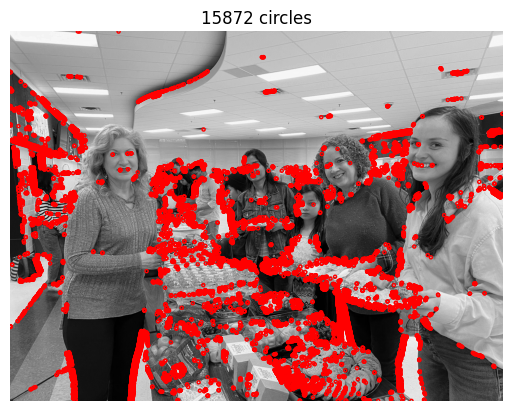

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_LoG_filter(sigma):
    # Generate Laplacian of Gaussian (LoG) filter
    size = int(2 * np.ceil(3 * sigma) + 1)
    kernel = cv2.getGaussianKernel(size, sigma)
    kernel_2d = np.outer(kernel, kernel.T)
    LoG = cv2.Laplacian(kernel_2d, cv2.CV_64F)
    return LoG

def build_Laplacian_scale_space(image, sigma, num_scales):
    # Build Laplacian scale space
    scale_space = []
    for i in range(num_scales):
        scale = sigma * (2 ** i)
        LoG = generate_LoG_filter(scale)
        filtered_image = cv2.filter2D(image, cv2.CV_64F, LoG)
        scale_space.append(filtered_image ** 2)  # Save square of Laplacian response
    return scale_space

def non_maximum_suppression(scale_space):
    # Perform non-maximum suppression in scale space
    suppressed_space = []
    for i in range(1, len(scale_space) - 1):
        prev_scale = scale_space[i - 1]
        curr_scale = scale_space[i]
        next_scale = scale_space[i + 1]
        suppressed = np.where((curr_scale > prev_scale) & (curr_scale > next_scale), curr_scale, 0)
        suppressed_space.append(suppressed)
    return suppressed_space

def detect_blobs(suppressed_space, threshold, radius_factor):
    # Detect blobs and return their coordinates and scales
    blobs = []
    for i, suppressed in enumerate(suppressed_space):
        indices = np.argwhere(suppressed > threshold)
        for index in indices:
            scale = radius_factor * (2 ** i)
            blobs.append((index[1], index[0], scale))  # (x, y, scale)
    return blobs

def display_blobs(image, blobs):
    """
    # Display resulting circles at their characteristic scales
    image_with_blobs = image.copy()
    for blob in blobs:
        x, y, scale = blob
        radius = int(scale)
        cv2.circle(image_with_blobs, (x, y), radius, (0, 255, 0), 2)
    plt.imshow(image_with_blobs, cmap='gray')
    plt.axis('off')
    plt.show()
    """
    cx = [int(blob[0]) for blob in blobs]
    cy = [int(blob[1]) for blob in blobs]
    rad = [int(blob[2]) for blob in blobs]
    show_all_circles(image, cx, cy, rad, color='r')

def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.axis('off')
    plt.show()    
    
def laplacian_blob_detector(image_path, sigma, num_scales, threshold, radius_factor):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Build Laplacian scale space
    scale_space = build_Laplacian_scale_space(image, sigma, num_scales)
    
    # Perform non-maximum suppression
    suppressed_space = non_maximum_suppression(scale_space)
    
    # Detect blobs
    blobs = detect_blobs(suppressed_space, threshold, radius_factor)
    
    # Display blobs
    display_blobs(image, blobs)

# Parameters
sigma = 1.6  # Standard deviation of Gaussian kernel
num_scales = 8  # Number of scales in the scale space
threshold = 10  # Threshold for blob detection
radius_factor = 5  # Factor for characteristic scale

# Path to the image
image_path = 'hw3_images/Pics/Potluck.jpg'

# Run Laplacian blob detector
laplacian_blob_detector(image_path, sigma, num_scales, threshold, radius_factor)
